## Описание проекта

Исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 


### Содержание
* <a href='#Подготовка данных'>1. Подготовка.
* <a href='#Анализ'>2. Анализ.
    * <a href='#Cкользящее среднее'>2.1 Cкользящее среднее.
    * <a href='#Cезонность'> 2.2 Cезонность.
    * <a href='#Cтационарные ряды'> 2.3 Cтационарные ряды.
* <a href='#Обучение'> 3. Обучение.
* <a href='#Тестирование'> 4. Тестирование.

<a id='Подготовка данных'></a>
# 1. Подготовка

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings; warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(data.head())
display(data.info())
print('Пропуски:')
display(data.isna().sum())
print('Дубликаты:')
display(data.duplicated().sum())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Пропуски:


num_orders    0
dtype: int64

Дубликаты:


26415

# 2. Анализ
<a id='Анализ'></a>

In [3]:
# проверим данные на однородность и монотонность
data.index.is_monotonic

True

In [4]:
# посмотрим на дубликаты
data[data.duplicated()]
# в данном случае видимо этот метод некорректно работает с датаиндексами

,num_orders
datetime,
2018-03-01 02:10:00,12
2018-03-01 02:20:00,19
2018-03-01 03:00:00,8
2018-03-01 03:10:00,17
2018-03-01 03:20:00,7
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


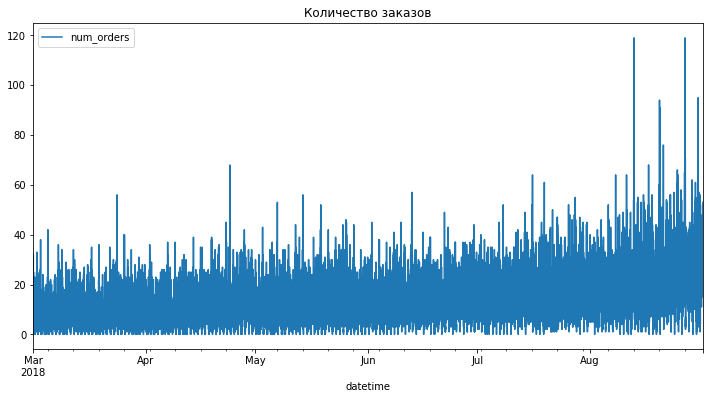

In [5]:
# так же посмотрим на данные визуально
data.plot(figsize=(12, 6), title='Количество заказов')

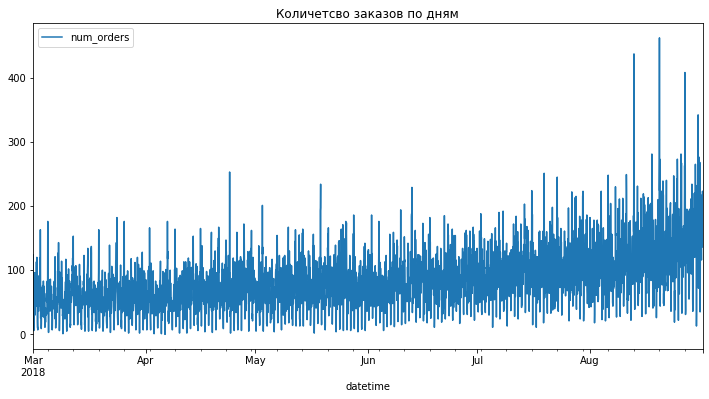

In [6]:
data = data.resample('1H').sum()
data.plot(figsize=(12, 6), title='Количетсво заказов по дням')

## Посмотрим на скользящее среднее
<a id='Cкользящее среднее'></a>

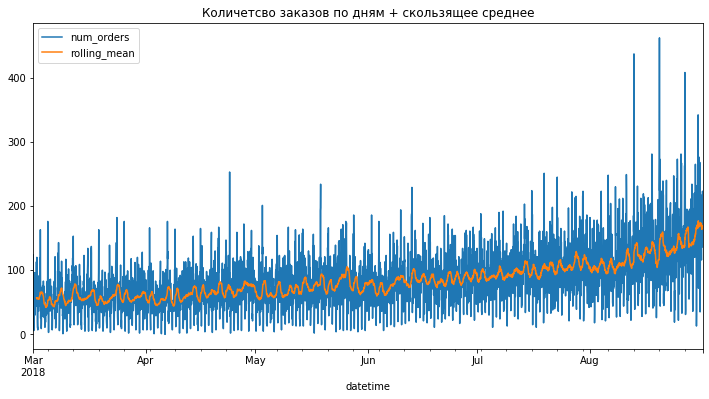

In [7]:
data['rolling_mean'] = data.rolling(24).mean()
data.plot(figsize=(12, 6), title='Количетсво заказов по дням + скользящее среднее')

## Посмотрим на сезонность
<a id='Cезонность'></a>

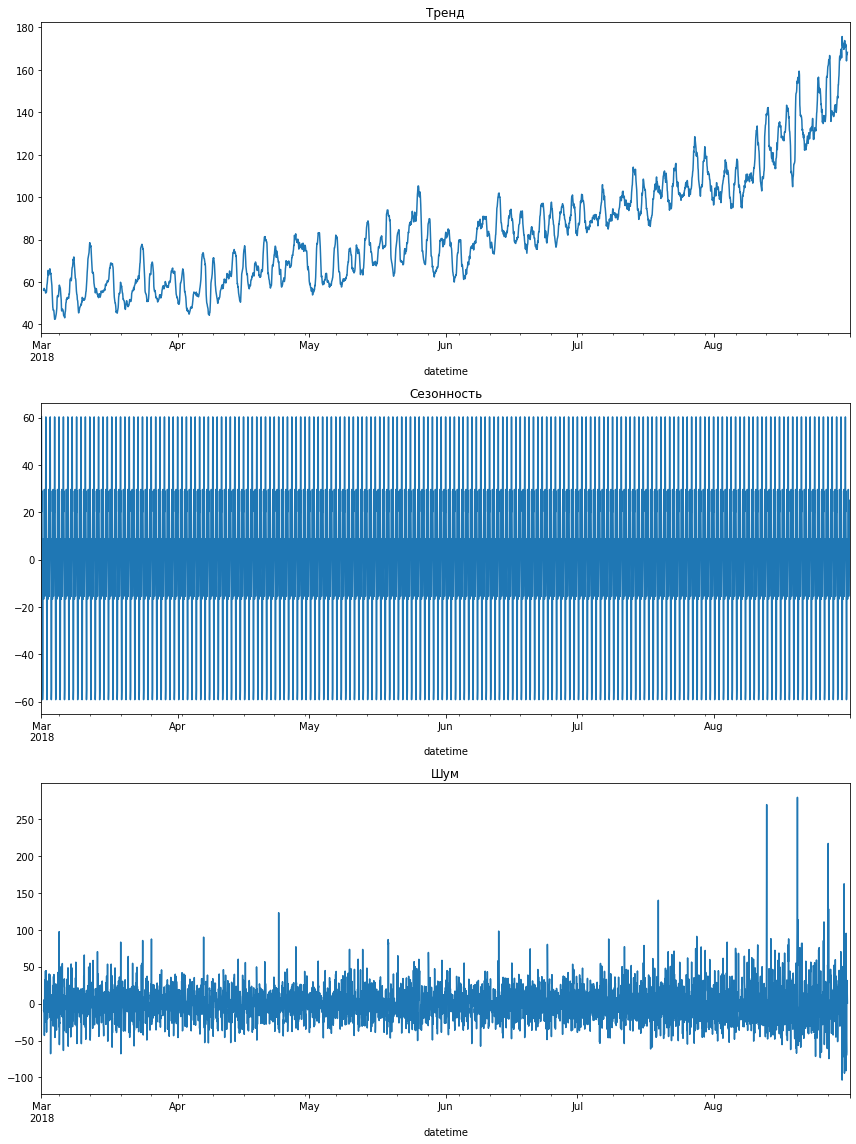

In [8]:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(12, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

Так сложно оценить сезонность, попробую подругому (возможно не самый оптимальный вариант).

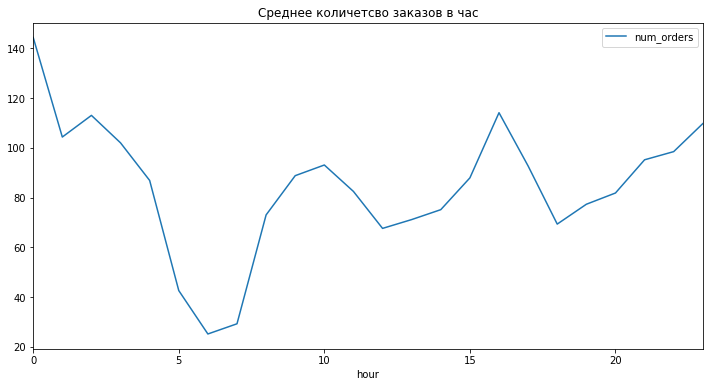

In [9]:
data['hour'] = data.index.hour
daily_seasons = data.pivot_table(index='hour', values='num_orders', aggfunc='mean')
daily_seasons.plot(figsize=(12, 6), title='Среднее количетсво заказов в час')

# Посмотрим на стационарные ряды
<a id='Cтационарные ряды'></a>

In [10]:
data['std'] = data['num_orders'].rolling(24).std()

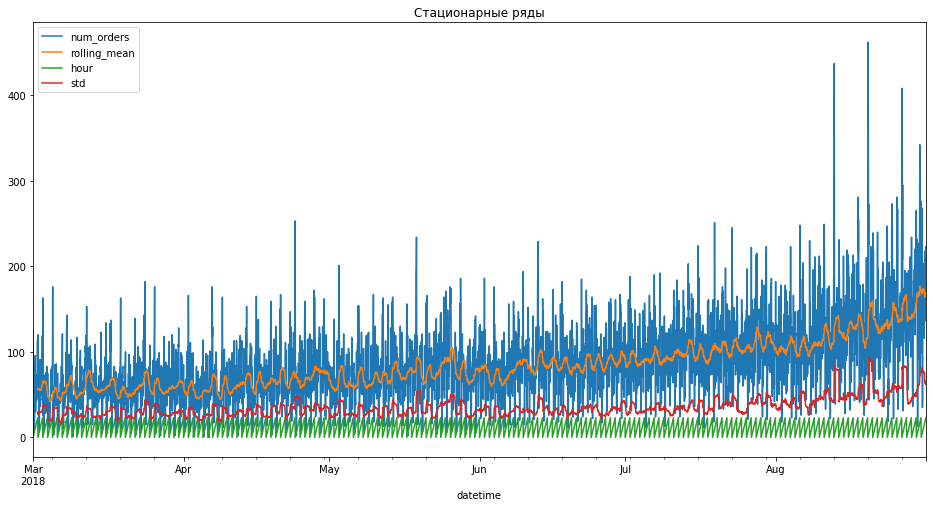

In [11]:
data.plot(figsize=(16, 8), title='Стационарные ряды')

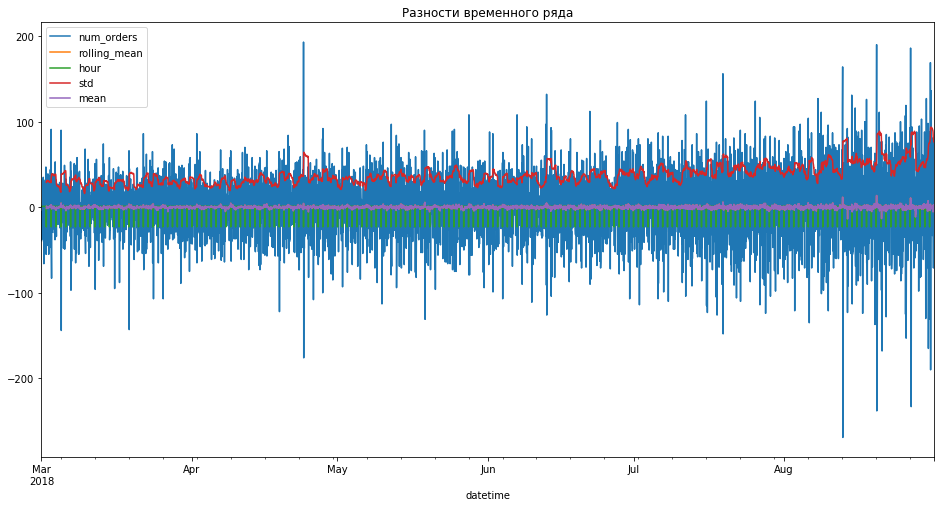

In [12]:
data_shifted = data
data_shifted  = data_shifted  - data.shift()# < напишите код здесь >
data_shifted ['mean'] = data_shifted ['num_orders'].rolling(24).mean()
data_shifted ['std'] = data_shifted ['num_orders'].rolling(24).std()
data_shifted .plot(figsize=(16, 8), title='Разности временного ряда')

# Вывод


Подготовим данные для обучения, уберем лишние признаки и создадим нужные.

In [13]:
data

,num_orders,rolling_mean,hour,std
datetime,,,,
2018-03-01 00:00:00,124,NaN,0,NaN
2018-03-01 01:00:00,85,NaN,1,NaN
2018-03-01 02:00:00,71,NaN,2,NaN
2018-03-01 03:00:00,66,NaN,3,NaN
2018-03-01 04:00:00,43,NaN,4,NaN
...,...,...,...,...
2018-08-31 19:00:00,136,167.541667,19,63.268908
2018-08-31 20:00:00,154,168.041667,20,63.105487
2018-08-31 21:00:00,159,166.416667,21,62.801908


In [14]:
data = data.drop(['rolling_mean', 'std'], axis=1)
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data

,num_orders,hour,month,day,dayofweek
datetime,,,,,
2018-03-01 00:00:00,124,0,3,1,3
2018-03-01 01:00:00,85,1,3,1,3
2018-03-01 02:00:00,71,2,3,1,3
2018-03-01 03:00:00,66,3,3,1,3
2018-03-01 04:00:00,43,4,3,1,3
...,...,...,...,...,...
2018-08-31 19:00:00,136,19,8,31,4
2018-08-31 20:00:00,154,20,8,31,4
2018-08-31 21:00:00,159,21,8,31,4


In [15]:
def make_features_and_prepare(data, max_lag, rolling_mean_size):
    
    dataframe = data.copy()
    
    for lag in range(1, max_lag + 1):
        dataframe['lag_{}'.format(lag)] = dataframe['num_orders'].shift(lag)

    dataframe['rolling_mean'] =  dataframe['num_orders'].shift().rolling(rolling_mean_size).mean()
    dataframe = dataframe.dropna()
    
    tuned_train, tuned_test = train_test_split(dataframe, shuffle=False, test_size=0.1)
    
    tuned_train_features = tuned_train.drop('num_orders', axis=1)
    tuned_train_target = tuned_train['num_orders']
    
    tuned_test_features = tuned_test.drop('num_orders', axis=1)
    tuned_test_target = tuned_test['num_orders']
    
    return tuned_train_features, tuned_train_target, tuned_test_features, tuned_test_target

In [16]:
train_features, train_target, test_features, test_target = make_features_and_prepare(data, 4, 4)
test_features

,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-08-13 14:00:00,14,8,13,0,119.0,92.0,144.0,156.0,127.75
2018-08-13 15:00:00,15,8,13,0,102.0,119.0,92.0,144.0,114.25
2018-08-13 16:00:00,16,8,13,0,175.0,102.0,119.0,92.0,122.00
2018-08-13 17:00:00,17,8,13,0,144.0,175.0,102.0,119.0,135.00
2018-08-13 18:00:00,18,8,13,0,152.0,144.0,175.0,102.0,143.25
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,19,8,31,4,207.0,217.0,197.0,116.0,184.25
2018-08-31 20:00:00,20,8,31,4,136.0,207.0,217.0,197.0,189.25
2018-08-31 21:00:00,21,8,31,4,154.0,136.0,207.0,217.0,178.50


# 3. Обучение
<a id='Обучение'></a>
Рабзобьём на выборки:

In [17]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
print(f'Параметры train: Даты от {train.index.min()} до {train.index.max()} и длинной {train.shape[0]}')
print(f'Параметры test: Даты от {test.index.min()} до {test.index.max()} и длинной {test.shape[0]}')

Параметры train: Даты от 2018-03-01 00:00:00 до 2018-08-13 13:00:00 и длинной 3974
Параметры test: Даты от 2018-08-13 14:00:00 до 2018-08-31 23:00:00 и длинной 442


In [18]:
# выделим признаки
# из тренирововочной
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
# из тестовой
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Напишем функцию для кросс валидации временных рядов.

In [19]:
def cv_timeline(model, n_splits, features, target):
    tscv = TimeSeriesSplit(n_splits = n_splits)
    rmse = []

    for train_index, test_index in tscv.split(features):
        # features
        cv_train_features, cv_test_features = features.iloc[train_index], features.iloc[test_index]
        # target
        cv_train_target, cv_test_target = target.iloc[train_index], target.iloc[test_index]
    
        model.fit(cv_train_features, cv_train_target)
    
        predictions = model.predict(cv_test_features)
        rmse.append(np.sqrt(mean_squared_error(cv_test_target, predictions)))
    
    return rmse

## Линейная регрессия

В первом случае сделаем кросс-валидацию своей функцией. На оригинальных данны, т.е. в которых признаки только номер месяца, число, час и день недели.

In [20]:
# зададим разбиение для кросс-валидации по принципам подходящим для таймлайнов
tscv = TimeSeriesSplit(n_splits=4)
model = LinearRegression()
print(np.mean(cv_timeline(model, 4, train_features, train_target)))

35.974281511735846


In [21]:
def best_quantity_of_features_finder(data, max_lag, rolling_mean_size, model, random=None, param_search=None):
    score_table = pd.DataFrame({'max_lag': [],
                           'rolling_mean_size': [],
                           'RMSE': []
                           })
    if random==None:
        for lag in range(1, max_lag, 1):
            for rolling in range(1, rolling_mean_size, 1):
                train_features, train_target, test_features, test_target = make_features_and_prepare(data, lag, rolling)
                rmse = np.sqrt(abs(cross_val_score(model, 
                                                   train_features, 
                                                   train_target, 
                                                   scoring='neg_mean_squared_error', 
                                                   cv=tscv)).mean())
                score_table = score_table.append({'max_lag': lag,
                                                  'rolling_mean_size': rolling,
                                                  'RMSE': rmse,
                                                  }, ignore_index=True)
    else:
        score_table['best_params'] = ''
        for lag in range(1, max_lag, 5):
            for rolling in range(1, rolling_mean_size, 5):
                train_features, train_target, test_features, test_target = make_features_and_prepare(data, lag, rolling)
                gsearch = RandomizedSearchCV(estimator=model, 
                                             cv=tscv,
                                             scoring='neg_mean_squared_error',
                                             param_distributions=param_search,
                                             n_iter=4)
                gsearch.fit(train_features, train_target)
                rmse = np.sqrt(abs(gsearch.best_score_))
                best_params = gsearch.best_params_.values()
                score_table = score_table.append({'max_lag': lag,
                                                  'rolling_mean_size': rolling,
                                                  'RMSE': rmse,
                                                  'best_params': best_params,
                                                  }, ignore_index=True)
        
    print('Лучший результат:')
    print(score_table.sort_values(by='RMSE', ascending=True).head(1))

Найдём оптимальное количество признаков с помощью написанной выше функции. В данном случае будем использовать готовую кросс-валидацию из sklearna.

In [22]:
%%time
best_quantity_of_features_finder(data, 26, 26, model)

Лучший результат:
     max_lag  rolling_mean_size       RMSE
587     24.0               13.0  27.438533
CPU times: user 2min 17s, sys: 2min 39s, total: 4min 57s
Wall time: 4min 57s


## Решающее дерево

На оригинальных данных:

In [23]:
for depth in range(1, 25, 1):
    dt_model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    print('Среднее значение RMSE для Решающее дерево с глубиной {} при кросс-валидации: {}'.format(depth, 
                                                np.mean(cv_timeline(dt_model, 4, train_features, train_target))))

Среднее значение RMSE для Решающее дерево с глубиной 1 при кросс-валидации: 39.45060645463098
Среднее значение RMSE для Решающее дерево с глубиной 2 при кросс-валидации: 38.10704255678246
Среднее значение RMSE для Решающее дерево с глубиной 3 при кросс-валидации: 34.16071713175124
Среднее значение RMSE для Решающее дерево с глубиной 4 при кросс-валидации: 32.54759397804516
Среднее значение RMSE для Решающее дерево с глубиной 5 при кросс-валидации: 30.980371350857638
Среднее значение RMSE для Решающее дерево с глубиной 6 при кросс-валидации: 30.07671935220181
Среднее значение RMSE для Решающее дерево с глубиной 7 при кросс-валидации: 29.44195452700844
Среднее значение RMSE для Решающее дерево с глубиной 8 при кросс-валидации: 29.57404850371301
Среднее значение RMSE для Решающее дерево с глубиной 9 при кросс-валидации: 29.779076925636357
Среднее значение RMSE для Решающее дерево с глубиной 10 при кросс-валидации: 30.373049041544633
Среднее значение RMSE для Решающее дерево с глубиной 11 

Найдём оптимальное количество признаков и гиперпараметры:

In [24]:
%%time
dt_model = DecisionTreeRegressor(random_state=42)
param_search = {'max_depth' : [i for i in range(1, 25)]}
best_quantity_of_features_finder(data, 26, 26, dt_model, random='yes', param_search=param_search)

Лучший результат:
   max_lag  rolling_mean_size       RMSE best_params
0      1.0                1.0  30.440141        (10)
CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.7 s


Лучший результат показало дерево с грубиной 8.

## Случайный лес

In [25]:
%%time
rf_model = RandomForestRegressor(random_state=42)
param_search = {'max_depth' : [i for i in range(1, 25)],
                'n_estimators': [i for i in range(10, 250, 10)]}
best_quantity_of_features_finder(data, 26, 26, rf_model, random='yes', param_search=param_search)

Лучший результат:
    max_lag  rolling_mean_size       RMSE best_params
18     16.0               16.0  25.987358   (190, 13)
CPU times: user 12min 7s, sys: 0 ns, total: 12min 7s
Wall time: 12min 8s


## XGBoost

In [26]:
%%time
xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
param_search = {'max_depth' : [i for i in range(1, 25)],
                'learning_rate': [i for i in np.arange(0.05, 0.20, 0.05)],
                'n_estimators': [i for i in range(10, 250, 10)]}
best_quantity_of_features_finder(data, 26, 26, xgb_model, random='yes', param_search=param_search)

Лучший результат:
    max_lag  rolling_mean_size       RMSE    best_params
17     16.0               11.0  26.146395  (110, 5, 0.1)
CPU times: user 6min 42s, sys: 0 ns, total: 6min 42s
Wall time: 6min 47s


# 4. Тестирование
<a id='Тестирование'></a>

In [28]:
%%time
lr_model = LinearRegression()
# добавим оптимальное количество признаков вычесленное на предыдущем этапе
train_features, train_target, test_features, test_target = make_features_and_prepare(data, 24, 13)
lr_model.fit(train_features, train_target)
lr_predictions = lr_model.predict(test_features)
print('RMSE Линейной регрессии на тестовой выборке:', np.sqrt(mean_squared_error(test_target, lr_predictions)))

RMSE Линейной регрессии на тестовой выборке: 45.8344740543336
CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 105 ms


In [29]:
%%time
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
# добавим оптимальное количество признаков вычесленное на предыдущем этапе
train_features, train_target, test_features, test_target = make_features_and_prepare(data, 1, 1)
dt_model.fit(train_features, train_target)
dt_predictions = dt_model.predict(test_features)
print('RMSE Решающего дерева на тестовой выборке:', np.sqrt(mean_squared_error(test_target, dt_predictions)))

RMSE Решающего дерева на тестовой выборке: 56.02896959054478
CPU times: user 28.4 ms, sys: 0 ns, total: 28.4 ms
Wall time: 25.7 ms


In [30]:
%%time
rf_model = RandomForestRegressor(random_state=42, max_depth=13, n_estimators=190)
# добавим оптимальное количество признаков вычесленное на предыдущем этапе
train_features, train_target, test_features, test_target = make_features_and_prepare(data, 16, 16)
rf_model.fit(train_features, train_target)
rf_predictions = rf_model.predict(test_features)
print('RMSE Случайного леса на тестовой выборке:', np.sqrt(mean_squared_error(test_target, rf_predictions)))

RMSE Случайного леса на тестовой выборке: 43.363781385221856
CPU times: user 7.58 s, sys: 0 ns, total: 7.58 s
Wall time: 7.68 s


In [31]:
%%time
xgb_model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=110, objective="reg:squarederror")
# добавим оптимальное количество признаков вычесленное на предыдущем этапе
train_features, train_target, test_features, test_target = make_features_and_prepare(data, 16, 11)
xgb_model.fit(train_features, train_target)
xgb_predictions = xgb_model.predict(test_features)
print('RMSE XGBoosta на тестовой выборке:', np.sqrt(mean_squared_error(test_target, xgb_predictions)))

RMSE XGBoosta на тестовой выборке: 42.61744338857424
CPU times: user 767 ms, sys: 0 ns, total: 767 ms
Wall time: 781 ms


Сделаем наивный прогноз для оценки адекватности модели. Будем оценивать предыдущим значением ряда.

In [32]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

print('RMSE для наивной модели на тестовой выборке:', np.sqrt(mean_squared_error(test, pred_previous)))

RMSE для наивной модели на тестовой выборке: 26.40768090650386


In [33]:
test

,num_orders,hour,month,day,dayofweek
datetime,,,,,
2018-08-13 14:00:00,102,14,8,13,0
2018-08-13 15:00:00,175,15,8,13,0
2018-08-13 16:00:00,144,16,8,13,0
2018-08-13 17:00:00,152,17,8,13,0
2018-08-13 18:00:00,104,18,8,13,0
...,...,...,...,...,...
2018-08-31 19:00:00,136,19,8,31,4
2018-08-31 20:00:00,154,20,8,31,4
2018-08-31 21:00:00,159,21,8,31,4


In [35]:
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]

print('RMSE для наивной модели на тестовой выборке:', np.sqrt(mean_squared_error(test['num_orders'], pred_previous)))

RMSE для наивной модели на тестовой выборке: 58.856486242815066


# Вывод:

На первом этапе работы данные были визуализированы для проведения анализа. Так же были добавлены признаки: месяц, число, день недели и час. И написана функция для включения таких признаков как скользящее среднее и отстающее значение.

На втором этапе, с помощью функции, в которой подбирается различное количество признаков и случайный набор гиперпараметров, находим оптимальные модели.
В условии задачи был дан порог принятия модели в 48 по метрике RMSE.
Все модели, кроме Решающего дерева, прошли этот порог. Лучший результат показал Случайный лес, с результатом 43.

Наивная модель же, предсказывающее значение на текущий час, значением предыдущего часа, показала результат 58.9.